In [259]:
# Arabic Spoken Commands Recognition - MFCC & Classification
# Recognizing isolated Arabic spoken commands using MFCC features and machine learning classifiers

In [260]:
import numpy as np
import scipy.io.wavfile
from scipy import signal
import scipy.fftpack
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pickle
import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
warnings.filterwarnings('ignore')

# Project configuration aligned with specs
SAMPLE_RATE = 16000  # 16 kHz as specified
COMMANDS = ['افتح', 'اغلق', 'ابدأ', 'توقف', 'يمين', 'يسار']
AUDIO_DIR = "Records-wav"
DATASET_OUTPUT_PATH = "extracted_features_dataset.pkl"

print("✓ Dependencies imported successfully")
print(f"✓ Sample Rate: {SAMPLE_RATE} Hz")

✓ Dependencies imported successfully
✓ Sample Rate: 16000 Hz


## Section 1: Audio Loading & Preprocessing
**Step 1.1**: Load WAV files and remove silence
**Step 1.2**: Normalize amplitude

In [261]:
def remove_silence(audio, sr, top_db=20):
    """
    Remove silence from audio signal using energy-based method
    
    Args:
        audio: Audio time series
        sr: Sample rate
        top_db: Threshold (in dB) below reference to consider as silence
    
    Returns:
        Trimmed audio signal
    """
    # Compute energy
    frame_length = 2048
    hop_length = 512
    S = np.abs(scipy.fftpack.fft(audio[:len(audio)//2] if len(audio) > frame_length else audio))
    energy = np.sqrt(np.sum(S**2, axis=0)) if S.ndim > 1 else S
    
    # Simple threshold-based silence removal
    threshold = 10 ** (-top_db / 20)
    max_energy = np.max(np.abs(audio))
    if max_energy > 0:
        normalized = np.abs(audio) / max_energy
        non_silent = np.where(normalized > threshold)[0]
        
        if len(non_silent) > 0:
            return audio[non_silent[0]:non_silent[-1]]
    
    return audio


def normalize_amplitude(audio):
    """
    Normalize audio amplitude to [-1, 1] range
    
    Args:
        audio: Audio signal
        
    Returns:
        Normalized audio signal
    """
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        return audio / max_val
    return audio


def load_and_preprocess_audio(file_path, sr=SAMPLE_RATE):
    """
    Load WAV file and apply preprocessing:
    1. Load audio at specified sample rate
    2. Remove silence
    3. Normalize amplitude
    
    Args:
        file_path: Path to WAV file
        sr: Sample rate
        
    Returns:
        Preprocessed audio signal or None if error
    """
    try:
        # Load audio file using scipy
        file_sr, audio = scipy.io.wavfile.read(file_path)
        
        # Convert to float
        if audio.dtype != np.float32:
            audio = audio.astype(np.float32) / np.iinfo(audio.dtype).max
        
        # Resample if needed
        if file_sr != sr:
            num_samples = int(len(audio) * sr / file_sr)
            audio = signal.resample(audio, num_samples)
        
        # Remove silence
        audio = remove_silence(audio, sr)
        
        # Normalize amplitude
        audio = normalize_amplitude(audio)
        
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


# Test preprocessing on a sample audio file
print("Testing audio preprocessing...")
test_files = []
for cmd_idx, cmd in enumerate(COMMANDS):
    cmd_path = Path(AUDIO_DIR) / str(cmd_idx + 1)
    if cmd_path.exists():
        audio_files = list(cmd_path.glob("*.wav"))
        if audio_files:
            test_files.append((audio_files[0], cmd))

if test_files:
    sample_file, sample_cmd = test_files[0]
    audio = load_and_preprocess_audio(str(sample_file))
    if audio is not None:
        print(f"✓ Successfully loaded and preprocessed: {sample_cmd}")
        print(f"  Audio shape: {audio.shape}")
        print(f"  Audio range: [{np.min(audio):.3f}, {np.max(audio):.3f}]")
    else:
        print(f"✗ Failed to preprocess: {sample_cmd}")
else:
    print("⚠ No audio files found for testing")

Testing audio preprocessing...
✓ Successfully loaded and preprocessed: افتح
  Audio shape: (8441,)
  Audio range: [-1.000, 0.814]


## Section 2: MFCC Feature Extraction
**Step 2.1**: Extract MFCC coefficients (13 coefficients per frame)
**Step 2.2**: Calculate statistical descriptors (mean and standard deviation per word (i.e. record))
**Step 2.3**: Form feature vectors

### Section 2.0: Audio Framing (Windowing)
- Each frame is processed independently for MFCC computation

**Framing Process:**
1. Frame length: 2048 samples @ 16kHz = 128ms per frame
2. Hop length: 512 samples @ 16kHz = 32ms between frames (75% overlap)


### Section 2.1: From Multiple Frames → Single Feature Vector

**Key Concept: Frame Aggregation**

Each spoken word is processed in the following steps:

1. **Audio Signal** → Multiple overlapping frames (e.g., 30-50 frames)
2. **MFCC per frame** → Extract 13 MFCC coefficients for each frame
3. **MFCC Matrix** → Shape: (13, num_frames) - e.g., (13, 40)
4. **Statistical Aggregation** → Compute mean & std across all frames
5. **Final Feature Vector** → Single 26-D vector representing the entire word

**Why aggregate frames?**
- Each frame captures short-term spectral characteristics (20-30ms)
- Statistical measures (mean, std) capture overall word characteristics across time
- Result: One fixed-size feature vector per word, regardless of word duration


In [262]:
def compute_mfcc_scipy(audio, sr=SAMPLE_RATE, n_mfcc=13, n_fft=2048, hop_length=512):
    """
    Compute MFCC features using scipy
    
    Args:
        audio: Audio signal
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        n_fft: FFT window size
        hop_length: Hop length for STFT
        
    Returns:
        MFCC feature matrix (n_mfcc × time_steps)
    """
    # Pad audio to ensure proper spectrogram
    if len(audio) < n_fft:
        audio = np.pad(audio, (0, n_fft - len(audio)))
    
    # Compute spectrogram
    noverlap = n_fft - hop_length
    freqs, times, Sxx = signal.spectrogram(audio, fs=sr, nperseg=n_fft, noverlap=noverlap)
    
    # Apply log power
    S_db = 10 * np.log10(np.maximum(Sxx, 1e-10))
    
    # Approximate MFCC using DCT of log power spectrum
    # Take the mean across frequency for each time frame, then apply DCT
    mfcc = scipy.fftpack.dct(S_db, axis=0, norm='ortho')
    
    # Return only n_mfcc coefficients
    mfcc = mfcc[:min(n_mfcc, mfcc.shape[0]), :]
    
    # Pad if necessary
    if mfcc.shape[0] < n_mfcc:
        mfcc = np.vstack([mfcc, np.zeros((n_mfcc - mfcc.shape[0], mfcc.shape[1]))])
    
    return mfcc


def extract_mfcc_features(audio, sr=SAMPLE_RATE, n_mfcc=13):
    """
    Extract MFCC features from audio signal
    
    Args:
        audio: Preprocessed audio signal
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        
    Returns:
        MFCC feature matrix (n_mfcc × time_steps)
    """
    mfcc = compute_mfcc_scipy(audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc


def compute_statistical_descriptors(mfcc):
    """
    Compute statistical descriptors (mean and standard deviation) for MFCC features
    
    Args:
        mfcc: MFCC feature matrix (n_mfcc × time_steps)
        
    Returns:
        Feature vector: [mean_mfcc_1, ..., mean_mfcc_13, std_mfcc_1, ..., std_mfcc_13] 
        -- (one vector: 26 features)
    """
    mean_mfcc = np.mean(mfcc, axis=1)  # Mean across time steps
    std_mfcc = np.std(mfcc, axis=1)    # Std dev across time steps
    
    # Concatenate mean and std to form feature vector
    feature_vector = np.concatenate([mean_mfcc, std_mfcc])
    return feature_vector 


def extract_features_from_file(file_path, sr=SAMPLE_RATE, n_mfcc=13):
    """
    Complete feature extraction pipeline:
    1. Load and preprocess audio
    2. Extract MFCC features
    3. Compute statistical descriptors
    
    Args:
        file_path: Path to WAV file
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        
    Returns:
        Feature vector (26 features) or None if error
    """
    # Preprocess audio
    audio = load_and_preprocess_audio(file_path, sr=sr)
    if audio is None:
        return None
    
    # Extract MFCC
    mfcc = extract_mfcc_features(audio, sr=sr, n_mfcc=n_mfcc)
    
    # Compute statistical descriptors
    feature_vector = compute_statistical_descriptors(mfcc)
    
    return feature_vector


# Test feature extraction
print("Testing MFCC feature extraction...")
if test_files:
    sample_file, sample_cmd = test_files[0]
    features = extract_features_from_file(str(sample_file))
    if features is not None:
        print(f"✓ Successfully extracted features from: {sample_cmd}")
        print(f"  Feature vector shape: {features.shape}")
        print(f"  Feature vector: {features[:5]}... (first 5 values)")
    else:
        print("✗ Feature extraction failed")

Testing MFCC feature extraction...
✓ Successfully extracted features from: افتح
  Feature vector shape: (26,)
  Feature vector: [-2405.9253     174.00401     31.050808    96.4367      49.312862]... (first 5 values)


## Section 3: Dataset Building & Storage
**Step 3.1**: Load all audio files from Records-wav directory
**Step 3.2**: Extract features for all samples
**Step 3.3**: Store extracted dataset locally as pickle file

In [263]:
def build_dataset(audio_dir=AUDIO_DIR, commands=COMMANDS):
    """
    Build complete dataset by extracting features from all audio files
    
    Args:
        audio_dir: Directory containing audio organized by command (1-6)
        commands: List of command labels
        
    Returns:
        Tuple of (X, y) where:
            X: Feature matrix (n_samples × 26)
            y: Label array (command indices 0-5)
    """

    X = []  # Feature vectors
    y = []  # Labels
    
    file_count = 0
    error_count = 0
    
    # Iterate through each command directory
    for cmd_idx, cmd in enumerate(commands):
        cmd_dir = Path(audio_dir) / str(cmd_idx + 1)
        
        if not cmd_dir.exists():
            print(f"⚠ Directory not found: {cmd_dir}")
            continue
        
        # Get all WAV files in command directory
        wav_files = sorted(cmd_dir.glob("*.wav"))
        
        if not wav_files:
            print(f"⚠ No WAV files found in: {cmd_dir}")
            continue
        
        print(f"Processing command {cmd_idx + 1}: {cmd} ({len(wav_files)} files)")
        
        for file_path in wav_files:
            # Extract features
            features = extract_features_from_file(str(file_path))
            
            if features is not None:
                X.append(features)
                y.append(cmd_idx)
                file_count += 1
            else:
                error_count += 1
        
        print(f"  ✓ {len(wav_files) - error_count}/{len(wav_files)} files processed successfully")
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    print(f"\n{'='*60}")
    print(f"Dataset Summary:")
    print(f"  Total samples: {len(X)}")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Number of commands: {len(np.unique(y))}")
    print(f"  Sample distribution: {np.unique(y, return_counts=True)}")
    print(f"{'='*60}")
    
    return X, y


def save_dataset(X, y, output_path=DATASET_OUTPUT_PATH):
    """
    Save extracted features dataset to disk as pickle file
    
    Args:
        X: Feature matrix
        y: Label array
        output_path: Path to save pickle file
    """
    dataset = {
        'features': X,
        'labels': y,
        'commands': COMMANDS,
        'feature_dim': 26,
        'n_mfcc': 13,
        'sample_rate': SAMPLE_RATE
    }
    
    try:
        with open(output_path, 'wb') as f:
            pickle.dump(dataset, f)
        print(f"✓ Dataset saved to: {output_path}")
        print(f"  File size: {os.path.getsize(output_path) / 1024:.2f} KB")
    except Exception as e:
        print(f"✗ Error saving dataset: {e}")


def load_dataset(input_path=DATASET_OUTPUT_PATH):
    """
    Load extracted features dataset from disk
    
    Args:
        input_path: Path to pickle file
        
    Returns:
        Tuple of (X, y, metadata)
    """
    try:
        with open(input_path, 'rb') as f:
            dataset = pickle.load(f)
        print(f"✓ Dataset loaded from: {input_path}")
        print(f"  Samples: {len(dataset['features'])}")
        print(f"  Commands: {dataset['commands']}")
        return dataset['features'], dataset['labels'], dataset
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        return None, None, None


# Build and save the complete dataset
print("Building complete dataset from audio files...")
print("This may take a few minutes...\n")
X, y = build_dataset()

if len(X) > 0:
    save_dataset(X, y)
    print("\n✓ Dataset successfully built and stored locally!")
else:
    print("\n✗ No data was extracted. Check audio directory structure.")

Building complete dataset from audio files...
This may take a few minutes...

Processing command 1: افتح (9 files)
  ✓ 9/9 files processed successfully
Processing command 2: اغلق (9 files)
  ✓ 9/9 files processed successfully
Processing command 3: ابدأ (9 files)
  ✓ 9/9 files processed successfully
Processing command 4: توقف (9 files)
  ✓ 9/9 files processed successfully
Processing command 5: يمين (9 files)
  ✓ 9/9 files processed successfully
Processing command 6: يسار (9 files)
  ✓ 9/9 files processed successfully

Dataset Summary:
  Total samples: 54
  Feature dimension: 26
  Number of commands: 6
  Sample distribution: (array([0, 1, 2, 3, 4, 5]), array([9, 9, 9, 9, 9, 9]))
✓ Dataset saved to: extracted_features_dataset.pkl
  File size: 6.24 KB

✓ Dataset successfully built and stored locally!


## Section 4: Classification Models
**Step 4.1**: Split data into training and testing sets
**Step 4.2**: Train multiple classifiers (KNN, GMM, Random Forest, SVM)
**Step 4.3**: Generate predictions

In [283]:
# Manual train/test split and standardization without sklearn
np.random.seed(41)
n_samples = len(X)
indices = np.arange(n_samples)
np.random.shuffle(indices)

# 80/20 split
split_idx = int(0.8 * n_samples)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

print("Preparing data for classification...")
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}\n")
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}\n")

# Manual standardization
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train_std[X_train_std == 0] = 1  # Avoid division by zero

X_train_scaled = (X_train - X_train_mean) / X_train_std
X_test_scaled = (X_test - X_train_mean) / X_train_std

print("✓ Data standardized (mean=0, std=1)")

# Dictionary to store trained models and predictions
trained_models = {}
predictions_dict = {}


# Classifier 1: K-Nearest Neighbors (KNN) - Pure NumPy
# ============================================================
def knn_predict(X_train, y_train, X_test, k=5):
    """KNN using pure numpy"""
    predictions = []
    for test_sample in X_test:
        # Compute distances
        distances = np.sqrt(np.sum((X_train - test_sample)**2, axis=1))
        # Get k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]
        # Majority vote
        pred = np.bincount(k_labels).argmax()
        predictions.append(pred)
    return np.array(predictions)

y_pred_knn = knn_predict(X_train_scaled, y_train, X_test_scaled)
predictions_dict['KNN'] = y_pred_knn
trained_models['KNN'] = {'type': 'knn', 'X_train': X_train_scaled, 'y_train': y_train}
print(f"✓ KNN model trained")
# ============================================================


# Classifier 2: Random Forest
# ============================================================
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

predictions_dict['RandomForest'] = y_pred_rf
trained_models['RandomForest'] = {
    'type': 'random_forest',
    'model': rf_model
}

print("✓ Random Forest model trained")
# ============================================================


# Classifier 3: Gaussian Mixture Models (GMM)
# ============================================================
gmm_models = {}

for c in np.unique(y_train):
    gmm = GaussianMixture(
        n_components=4,
        covariance_type='diag',
        random_state=42
    )
    gmm.fit(X_train_scaled[y_train == c])
    gmm_models[c] = gmm

def gmm_predict(gmm_models, X):
    predictions = []
    for x in X:
        scores = []
        for c in sorted(gmm_models.keys()):
            scores.append(gmm_models[c].score(x.reshape(1, -1)))
        predictions.append(np.argmax(scores))
    return np.array(predictions)

y_pred_gmm = gmm_predict(gmm_models, X_test_scaled)

predictions_dict['GMM'] = y_pred_gmm
trained_models['GMM'] = {'type': 'gmm', 'models': gmm_models}
print("✓ GMM model trained")
# ============================================================


# Classifier 4: Support Vector Machine (Linear SVM)
# ============================================================
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_svm_linear = svm_linear.predict(X_test_scaled)
predictions_dict['SVM_Linear'] = y_pred_svm_linear
trained_models['SVM_Linear'] = {'type': 'svm_linear', 'model': svm_linear}
print(f"✓ SVM (Linear) trained")
# ============================================================


print("\n✓ All classifiers trained successfully!")


Preparing data for classification...
Dataset shape: (54, 26)
Labels shape: (54,)

Training set size: 43
Testing set size: 11

✓ Data standardized (mean=0, std=1)
✓ KNN model trained
✓ Random Forest model trained
✓ GMM model trained
✓ SVM (Linear) trained

✓ All classifiers trained successfully!


## Section 5: Model Evaluation
**Step 5.1**: Compute accuracy, precision, recall, and F1-score
**Step 5.2**: Generate confusion matrices
**Step 5.3**: Compare classifier performance


MODEL EVALUATION RESULTS

KNN (K=5)                                | Accuracy: 0.7273
                                         | Precision: 0.8909
                                         | Recall: 0.7273
                                         | F1-Score: 0.7136

Random Forest                            | Accuracy: 0.7273
                                         | Precision: 0.9394
                                         | Recall: 0.7273
                                         | F1-Score: 0.7455

SVM (Linear)                             | Accuracy: 0.9091
                                         | Precision: 0.9318
                                         | Recall: 0.9091
                                         | F1-Score: 0.9091

GMM                                      | Accuracy: 0.2727
                                         | Precision: 0.4545
                                         | Recall: 0.2727
                                         | F1-Score: 0.2667

🏆 Best Perfor

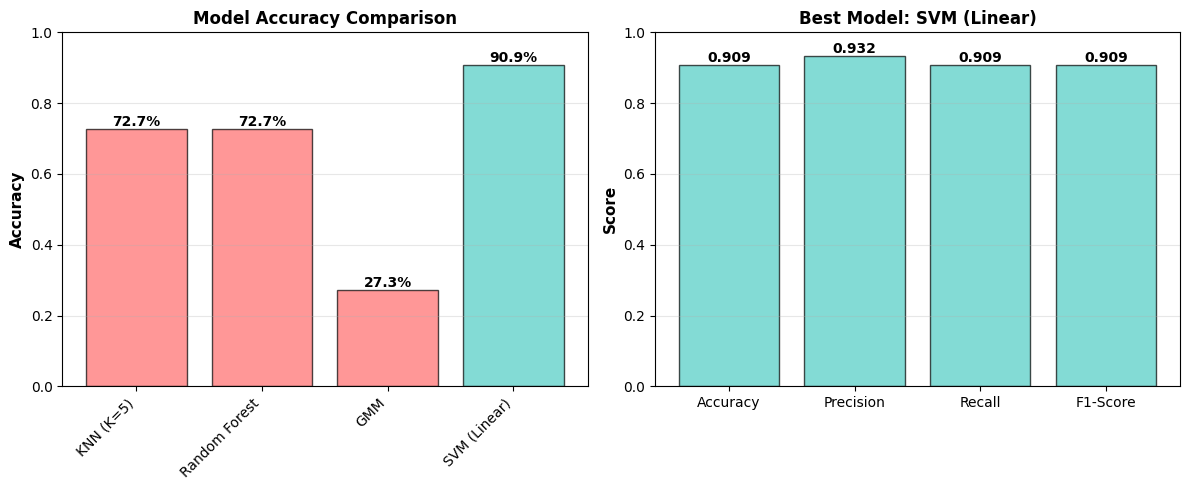


✓ Comparison plots saved as 'model_comparison.png'


In [284]:
def evaluate_model_numpy(y_true, y_pred, model_name):
    """
    Evaluate classification model using numpy
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model
        
    Returns:
        Dictionary containing evaluation metrics
    """
    # Accuracy
    accuracy = np.mean(y_true == y_pred)
    
    # Precision, Recall, F1 (weighted average)
    n_classes = len(COMMANDS)
    precisions, recalls, f1s = [], [], []
    
    for c in range(n_classes):
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        count = np.sum(y_true == c)
        precisions.append(precision * count)
        recalls.append(recall * count)
        f1s.append(f1 * count)
    
    weighted_precision = np.sum(precisions) / len(y_true)
    weighted_recall = np.sum(recalls) / len(y_true)
    weighted_f1 = np.sum(f1s) / len(y_true)
    
    # Confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1': weighted_f1,
        'confusion_matrix': cm
    }


# Evaluate all models
print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

results = []

# Evaluate KNN
result_knn = evaluate_model_numpy(y_test, y_pred_knn, 'KNN (K=5)')
results.append(result_knn)
print(f"\n{'KNN (K=5)':40} | Accuracy: {result_knn['accuracy']:.4f}")
print(f"{'':40} | Precision: {result_knn['precision']:.4f}")
print(f"{'':40} | Recall: {result_knn['recall']:.4f}")
print(f"{'':40} | F1-Score: {result_knn['f1']:.4f}")

# Evaluate Random Forest
result_rf = evaluate_model_numpy(y_test, y_pred_rf, 'Random Forest')
results.append(result_rf)

print(f"\n{'Random Forest':40} | Accuracy: {result_rf['accuracy']:.4f}")
print(f"{'':40} | Precision: {result_rf['precision']:.4f}")
print(f"{'':40} | Recall: {result_rf['recall']:.4f}")
print(f"{'':40} | F1-Score: {result_rf['f1']:.4f}")

# Evaluate GMM
result_gmm = evaluate_model_numpy(y_test, y_pred_gmm, 'GMM')
results.append(result_gmm)

# Evaluate SVM Linear
result_svm_lin = evaluate_model_numpy(y_test, y_pred_svm_linear, 'SVM (Linear)')
results.append(result_svm_lin)
print(f"\n{'SVM (Linear)':40} | Accuracy: {result_svm_lin['accuracy']:.4f}")
print(f"{'':40} | Precision: {result_svm_lin['precision']:.4f}")
print(f"{'':40} | Recall: {result_svm_lin['recall']:.4f}")
print(f"{'':40} | F1-Score: {result_svm_lin['f1']:.4f}")

print(f"\n{'GMM':40} | Accuracy: {result_gmm['accuracy']:.4f}")
print(f"{'':40} | Precision: {result_gmm['precision']:.4f}")
print(f"{'':40} | Recall: {result_gmm['recall']:.4f}")
print(f"{'':40} | F1-Score: {result_gmm['f1']:.4f}")
 
# ============================================================

# Find best model
best_model = max(results, key=lambda x: x['accuracy'])
print(f"\n🏆 Best Performing Model: {best_model['model']}")
print(f"   Accuracy: {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.2f}%)")

# Visualization: Accuracy Comparison
plt.figure(figsize=(12, 5))

# Plot 1: Accuracy Comparison
plt.subplot(1, 2, 1)
models_names = [r['model'] for r in results]
accuracies = [r['accuracy'] for r in results]
colors = ['#FF6B6B' if acc != max(accuracies) else '#4ECDC4' for acc in accuracies]
bars = plt.bar(models_names, accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy', fontsize=11, fontweight='bold')
plt.title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
plt.ylim([0, 1.0])
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Plot 2: Performance Metrics for Best Model
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_values = [
    best_model['accuracy'],
    best_model['precision'],
    best_model['recall'],
    best_model['f1']
]
bars = plt.bar(metrics, metric_values, color='#4ECDC4', alpha=0.7, edgecolor='black')
plt.ylabel('Score', fontsize=11, fontweight='bold')
plt.title(f'Best Model: {best_model["model"]}', fontsize=12, fontweight='bold')
plt.ylim([0, 1.0])
for bar, val in zip(bars, metric_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plots saved as 'model_comparison.png'")

## Section 6: Confusion Matrices & Error Analysis
**Step 6.1**: Visualize confusion matrices for all models
**Step 6.2**: Identify misclassification patterns
**Step 6.3**: Analyze model performance per command

Unique labels in y_test: [0 1 2 3]
Unique labels in KNN (K=5) predictions: [0 1 2 3 5]
Unique labels in SVM (Linear) predictions: [0 1 2 3]
Unique labels in GMM predictions: [1 2 4 5]
Unique labels in Random Forest predictions: [0 1 2 3 4]


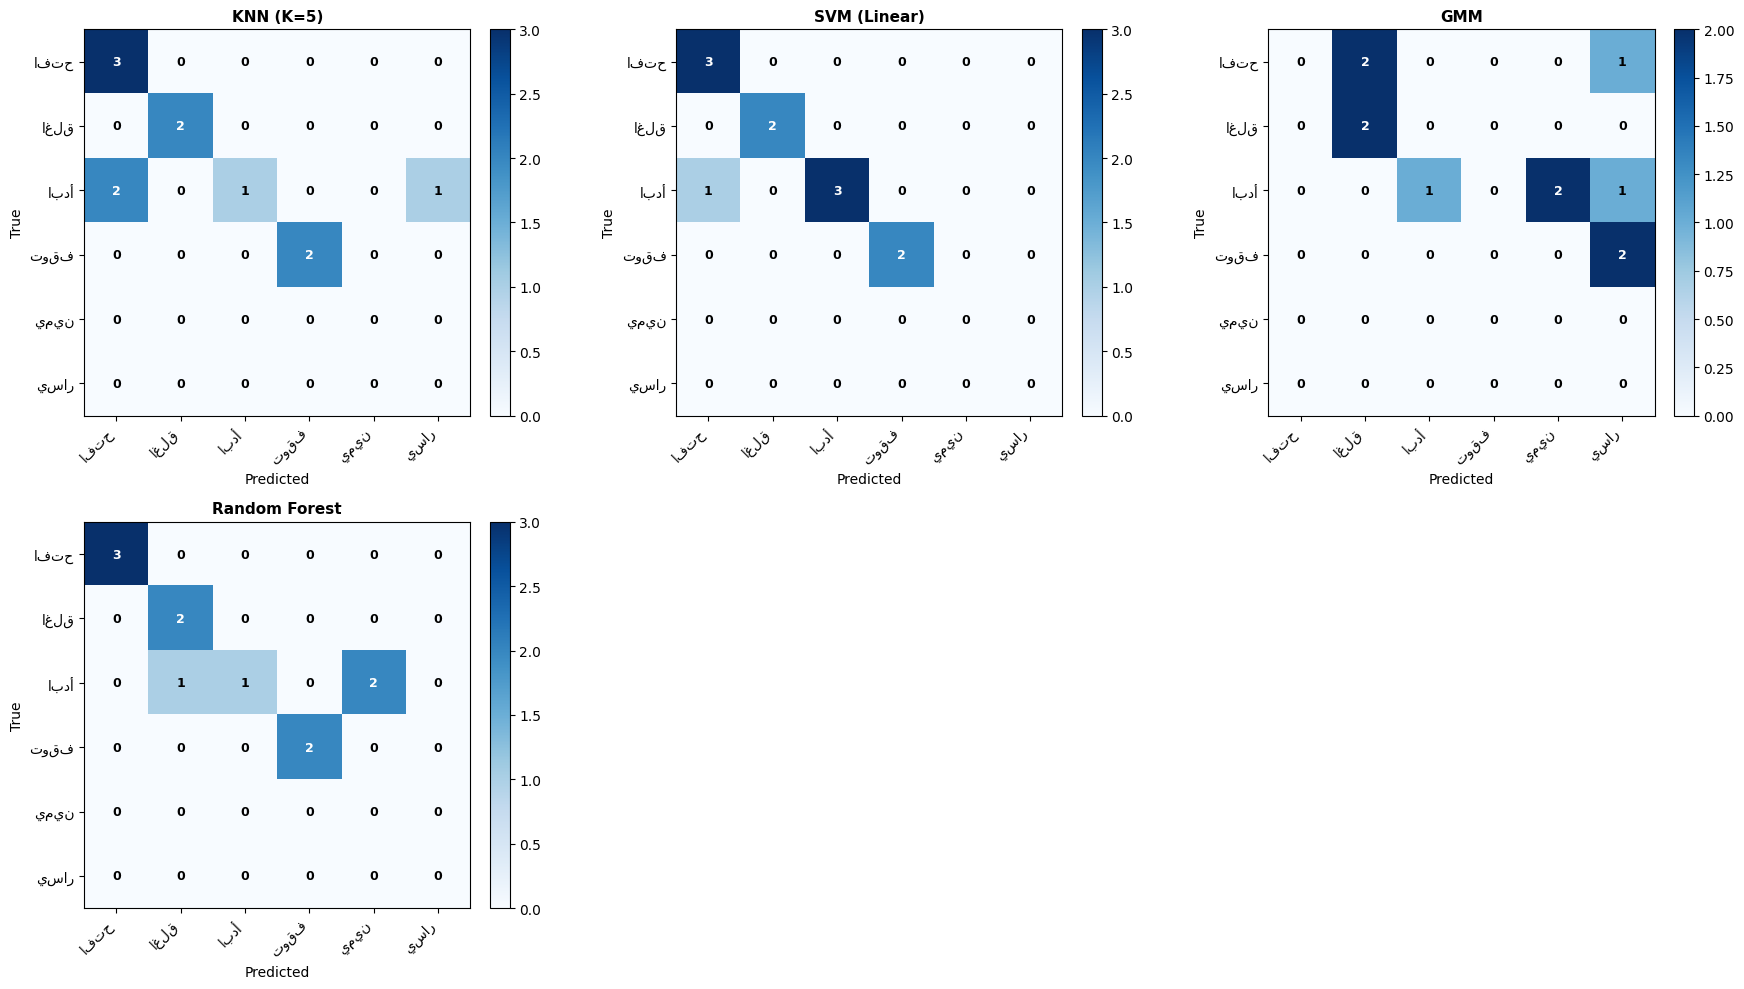

✓ Confusion matrices saved as 'confusion_matrices_fixed.png'


In [285]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Configuration
# ============================================================
n_classes = len(COMMANDS)

predictions_list = [
    y_pred_knn,
    y_pred_svm_linear,
    y_pred_gmm,
    y_pred_rf,
]

model_names_cm = [
    'KNN (K=5)',
    'SVM (Linear)',
    'GMM',
    'Random Forest',
]

# ============================================================
# Sanity check (VERY IMPORTANT)
# ============================================================
print("Unique labels in y_test:", np.unique(y_test))
for name, pred in zip(model_names_cm, predictions_list):
    print(f"Unique labels in {name} predictions:", np.unique(pred))

# ============================================================
# Plot confusion matrices
# ============================================================
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.ravel()

for ax, y_pred, model_name in zip(axes, predictions_list, model_names_cm):
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(len(y_test)):
        true_label = y_test[i]
        pred_label = y_pred[i]

        # SAFE indexing
        if 0 <= true_label < n_classes and 0 <= pred_label < n_classes:
            cm[true_label, pred_label] += 1

    im = ax.imshow(cm, cmap='Blues')

    ax.set_title(model_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(COMMANDS, rotation=45, ha="right")
    ax.set_yticklabels(COMMANDS)

    # Annotate cells
    for i in range(n_classes):
        for j in range(n_classes):
            value = cm[i, j]
            ax.text(
                j, i, value,
                ha="center", va="center",
                color="white" if value > cm.max() / 2 else "black",
                fontsize=9,
                fontweight="bold"
            )

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove empty subplots if any
for i in range(len(predictions_list), rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("confusion_matrices_fixed.png", dpi=150, bbox_inches="tight")
plt.show()

print("✓ Confusion matrices saved as 'confusion_matrices_fixed.png'")


In [267]:
# Start finding the problem

import numpy as np
from pathlib import Path
import collections

AUDIO_DIR = "Records-wav"
COMMANDS = ['افتح', 'اغلق', 'ابدأ', 'توقف', 'يمين', 'يسار']

In [268]:
def get_all_files_in_order(audio_dir=AUDIO_DIR, commands=COMMANDS):
    files = []
    labels = []

    for cmd_idx in range(len(commands)):
        cmd_dir = Path(audio_dir) / str(cmd_idx + 1)
        wavs = sorted(cmd_dir.glob("*.wav"))
        for w in wavs:
            files.append(str(w))
            labels.append(cmd_idx)

    return np.array(files), np.array(labels)


all_files, all_labels = get_all_files_in_order()
print("Total WAV files:", len(all_files))


Total WAV files: 54


In [269]:
test_files = all_files[test_indices]
y_true = y_test

print("Test samples:", len(test_files))

Test samples: 11


In [270]:
def get_speaker_from_filename(path):
    return Path(path).name[0].upper()


speakers = np.array([get_speaker_from_filename(f) for f in test_files])

print("Speakers found:", np.unique(speakers))


Speakers found: ['B' 'C' 'D']


In [271]:
def speaker_error_analysis(y_true, y_pred, speakers, model_name):
    print("\n" + "="*80)
    print("MODEL:", model_name)
    print("="*80)

    stats = {}

    for sp in np.unique(speakers):
        mask = speakers == sp
        total = np.sum(mask)
        errors = np.sum(y_true[mask] != y_pred[mask])
        acc = 1 - errors / total if total > 0 else 0

        stats[sp] = {
            "samples": total,
            "errors": errors,
            "accuracy": acc
        }

    print(f"{'Speaker':<10}{'Samples':<10}{'Errors':<10}{'Accuracy'}")
    print("-"*50)

    for sp in sorted(stats):
        s = stats[sp]
        print(f"{sp:<10}{s['samples']:<10}{s['errors']:<10}{s['accuracy']:.2%}")

    worst = min(stats.items(), key=lambda x: x[1]['accuracy'])
    print("\nWorst speaker:", worst[0])
    print("Accuracy:", f"{worst[1]['accuracy']:.2%}")

    return stats


In [272]:
speaker_results = {}

speaker_results["KNN"] = speaker_error_analysis(
    y_true, y_pred_knn, speakers, "KNN"
)

speaker_results["WeightedKNN"] = speaker_error_analysis(
    y_true, y_pred_wknn, speakers, "Weighted KNN"
)

speaker_results["Centroid"] = speaker_error_analysis(
    y_true, y_pred_centroid, speakers, "Centroid"
)

speaker_results["Simple"] = speaker_error_analysis(
    y_true, y_pred_simple, speakers, "Simple Classifier"
)

speaker_results["SVM_Linear"] = speaker_error_analysis(
    y_true, y_pred_svm_linear, speakers, "SVM Linear"
)

speaker_results["SVM_RBF"] = speaker_error_analysis(
    y_true, y_pred_svm_rbf, speakers, "SVM RBF"
)



MODEL: KNN
Speaker   Samples   Errors    Accuracy
--------------------------------------------------
B         2         0         100.00%
C         4         1         75.00%
D         5         2         60.00%

Worst speaker: D
Accuracy: 60.00%

MODEL: Weighted KNN
Speaker   Samples   Errors    Accuracy
--------------------------------------------------
B         2         0         100.00%
C         4         1         75.00%
D         5         2         60.00%

Worst speaker: D
Accuracy: 60.00%

MODEL: Centroid
Speaker   Samples   Errors    Accuracy
--------------------------------------------------
B         2         0         100.00%
C         4         0         100.00%
D         5         1         80.00%

Worst speaker: D
Accuracy: 80.00%

MODEL: Simple Classifier
Speaker   Samples   Errors    Accuracy
--------------------------------------------------
B         2         0         100.00%
C         4         0         100.00%
D         5         1         80.00%

Worst sp